# <font color = white > **Stochastic Simulation (5284STSI6Y) | MSc Computational Science at UvA** </font>

# <font color = LightGreen > **Assignment 2: Discrete-Event Simulation** </font>
*By Victor Piaskowski(15132625), Sanjhana Bhusal (14724383), and Lisa Pahladsingh(13846566)*

Link to Github Repository: https://github.com/BiggusVickus/Stochastic_Simulation

## <font color = LightBlue> **Exercise 1** </font>
#### <font color = Grey> ***MATHEMATICAL EXPLANATION (i)*** </font>
In an M/M/2 queue, the arrival rate per server is given by $\lambda$ and the service rate per server is given by $\mu$. The utilization per server is denoted by $\rho$ and is calculated as $\rho = \frac{\lambda}{c\mu}$. Therefore, for $c=2$ we get that $\rho = \frac{\lambda}{2\mu}$.

The Erlang C formula is used to determine the probability that an arriving customer has to wait for service, and it is given by:

$$
P_w = \frac{\left(\frac{\rho^2}{2(1-\rho)}\right)}{\sum_{k=0}^{1}\frac{\rho^k}{k!} + \frac{\rho^2}{2(1-\rho)}}
$$

The average number of customers in the system (queue and service) for an M/M/2 queue is represented by $L$ and can be expressed as:

$$
L = \lambda W_q
$$

where $W_q$ is the average waiting time in the queue for an M/M/2 system. This average waiting time $W_q$ is given by:

$$
W_q = \frac{P_w}{\lambda}
$$

For an M/M/2 queue, the average waiting time is usually shorter than that of an M/M/1 queue, particularly when the system load $\rho$ is close to 1, which suggests a high utilization of the servers. This efficiency is due to the distribution of the workload between the two servers, allowing the system to handle a higher volume of traffic before queues build up significantly.

#### <font color = Grey> ***MATHEMATICAL EXPLANATION (ii)*** </font>
Queing theory is applicable to many real-world scenario's. By looking at $\textit{performance measures}$, such as mean waiting time and the mean number of customers in a system, we can derive some characteristics about the system. We will be looking at the mean waiting time of two different types of queing, namely M/M/1 and M/M/c, with a closer look at M/M/2. Hence we will compare queing with one server and 2 servers respectively. In order to evaluate the mean waiting time for these two types, we need to establish some parameters:

- $E(S)$ = Mean sojourn time (waiting in queue + service time)
- $E(L)$ = Mean number of customers in the system
- $\lambda$ = Rate of arrivals
- $\mu$ = Rate of service
- $\rho$ = $\frac{\lambda}{\mu}$ (server utilization/load)
- $E(L)$ = $\lambda$ $\cdot$ $E(S)$ (Little's Law)

##### <font color = Black> ***M/M/1*** </font>
In a M/M/1 system the mean number of customers in the systems is defined as such: </br>


$ E(L) = \sum_{n=0}^{\infty} n \cdot p_n = \frac{\rho}{1- \rho} $

In order to find the mean number of customers in the queue $(E(L^q))$, the mean number of customers in service need to substracted from $E(L)$: </br>
$ E(L^q) = E(L) - \rho = \frac{\rho^2}{1- \rho} $. 

Finally, by applying Little's Law, we obtain the mean waiting time: </br>
$E(W) = \frac{\rho}{\mu} \cdot \frac{1}{1-\rho}$

##### <font color = Black> ***M/M/c*** </font>
The mean number of customers in the queue is given by: </br>
$ E(L^q) = \sum_{n=0}^{\infty} n \cdot p_{c+n} $ </br>
$        = \frac{p_c}{1 - \rho} \cdot \sum_{n=0}^{\infty} n \cdot (1- \rho) \cdot \rho^n $ </br>
$        = \pi_W \cdot \frac{\rho}{1 - \rho} $

By applying Little's Law, we obtain the mean waiting time: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{c \cdot \mu} $,
in case of two servers, this would yield in: </br>
$ E(W) = \pi_W \cdot \frac{1}{1 - \rho} \cdot \frac{1}{2 \cdot \mu} $









#### <font color = Grey> ***THEORETICAL EXPLANATION***</font>
In a queuing system where multiple servers are available (M/M/n), each server shares the task of handling incoming customers, as opposed to all customers lining up for a single server (M/M/1). This setup reduces the effective arrival rate of customers to each server because they are distributed across several servers. As a result, customers are likely to wait less because there is a higher chance that one of the servers will be free to help them sooner. Therefore, the system can manage more customer arrivals. This efficiency becomes especially significant when the system is close to its maximum capacity, denoted by a utilization value ($\rho$) near 1. At this point, the presence of multiple servers is more important, as they collectively handle the high volume of customers and keep wait times shorter than what a single server could achieve.

## <font color = LightBlue> **Exercise 2** </font>

In [126]:
import simpy
import random
import statistics
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import operator
import matplotlib.colors as mcolors

# Parameters
RANDOM_SEED = 42
SIM_TIME = 10000  # Simulation time in minutes
MU = 10  # Average service rate (1/MU is average service time)
NUM_SERVERS_1 = [1, 2, 4]  # Number of servers to simulate
NUM_SERVERS_2 = [1, 2, 4]  # Number of servers to simulate
RHO_VALUES = np.linspace(0.85, 0.99, 15)#[0.8, 0.9, 0.95, 0.99]  # Values of ρ to simulate


# Set the random seed for reproducibility
random.seed(RANDOM_SEED)

# Customer process
def customer(env, name, servers, wait_times_list):
    arrival_time = env.now
    with servers.request() as request:
        yield request
        wait = env.now - arrival_time
        wait_times_list.append(wait)
        service_time = random.expovariate(MU)
        yield env.timeout(service_time)

# Source process
def source(env, num_servers, rho, servers, wait_times_list):
    """Generate customers with arrival rate based on number of servers and rho."""
    while True:
        arrival_rate = rho * num_servers * MU
        yield env.timeout(random.expovariate(arrival_rate))
        name = f'Customer{env.now:7.4f}'
        env.process(customer(env, name, servers, wait_times_list))

# Simulation setup
def run_simulation(num_servers, rho, wait_times, priority):
    env = simpy.Environment()
    if (priority):
        servers = simpy.PriorityResource(env, capacity=num_servers)
    else:
        servers = simpy.Resource(env, capacity=num_servers)
    wait_times_list = wait_times[num_servers][rho]
    env.process(source(env, num_servers, rho, servers, wait_times_list))
    env.run(until=SIM_TIME)

# Run the simulation for each number of servers and ρ values
def main(num_servers, rho_values, wait_times, priority=False):
    if (priority):
        print(f'Running SJF simulation with {num_servers} servers')
    else:
        print(f'Running FIFO simulation with {num_servers} servers')
    wait_times = {n: {rho: [] for rho in RHO_VALUES} for n in num_servers}
    results = []  # Store results for plotting
    for num_servers in num_servers:
        for rho in rho_values:
            run_simulation(num_servers, rho, wait_times, priority)
            # Calculate mean waiting time and 95% confidence interval
            sample_wait_times = wait_times[num_servers][rho]
            mean_wait = statistics.mean(sample_wait_times)
            stdev_wait = statistics.stdev(sample_wait_times)
            sample_size = len(sample_wait_times)
            ci_low, ci_upp = scipy.stats.t.interval(0.95, df=sample_size-1, loc=mean_wait)
            results.append((num_servers, rho, mean_wait, ci_low, ci_upp))

            print(f'Number of servers: {num_servers}, ρ: {rho}, Mean wait time: {mean_wait:.2f}')
    return wait_times, results
# Store statistics
wait_times_1 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_1}
wait_times_2 = {n: {rho: [] for rho in RHO_VALUES} for n in NUM_SERVERS_2}

wait_times_1, results_1 = main(NUM_SERVERS_1, RHO_VALUES, wait_times_1, priority=False)
wait_times_2, results_2 = main(NUM_SERVERS_2, RHO_VALUES, wait_times_2, priority=True)
# Plotting the results
# for num_servers, rho, mean_wait, ci_lower, ci_upper in results:
#     plt.errorbar(rho, mean_wait, yerr=[[mean_wait - ci_lower], [ci_upper - mean_wait]], fmt='o', label=f'n={num_servers}')

# plt.xlabel('Traffic Intensity ($\\rho$)')
# plt.ylabel('Mean Waiting Time')
# plt.title('Mean Waiting Time vs Traffic Intensity for Different Numbers of Servers')
# plt.legend()
# plt.grid(True)
# plt.show()


# Prepare data for plotting



Running FIFO simulation with [1, 2, 4] servers
Number of servers: 1, ρ: 0.85, Mean wait time: 0.58
Number of servers: 1, ρ: 0.86, Mean wait time: 0.60
Number of servers: 1, ρ: 0.87, Mean wait time: 0.68
Number of servers: 1, ρ: 0.88, Mean wait time: 0.71
Number of servers: 1, ρ: 0.89, Mean wait time: 0.77
Number of servers: 1, ρ: 0.9, Mean wait time: 0.85
Number of servers: 1, ρ: 0.9099999999999999, Mean wait time: 1.12
Number of servers: 1, ρ: 0.9199999999999999, Mean wait time: 1.18
Number of servers: 1, ρ: 0.9299999999999999, Mean wait time: 1.25
Number of servers: 1, ρ: 0.94, Mean wait time: 1.62
Number of servers: 1, ρ: 0.95, Mean wait time: 1.60
Number of servers: 1, ρ: 0.96, Mean wait time: 1.99
Number of servers: 1, ρ: 0.97, Mean wait time: 2.61
Number of servers: 1, ρ: 0.98, Mean wait time: 4.24
Number of servers: 1, ρ: 0.99, Mean wait time: 15.79
Number of servers: 2, ρ: 0.85, Mean wait time: 0.25
Number of servers: 2, ρ: 0.86, Mean wait time: 0.28
Number of servers: 2, ρ: 0.

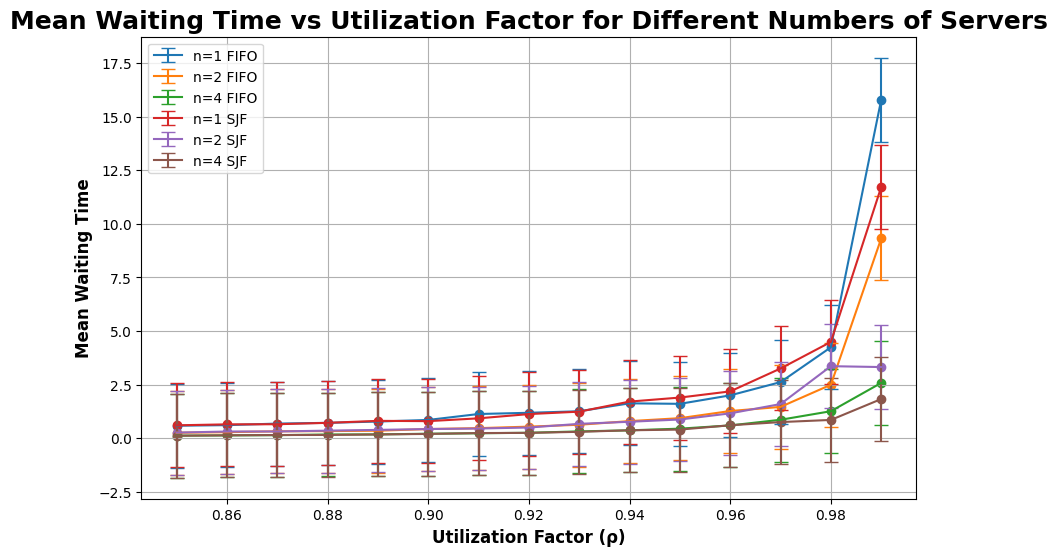

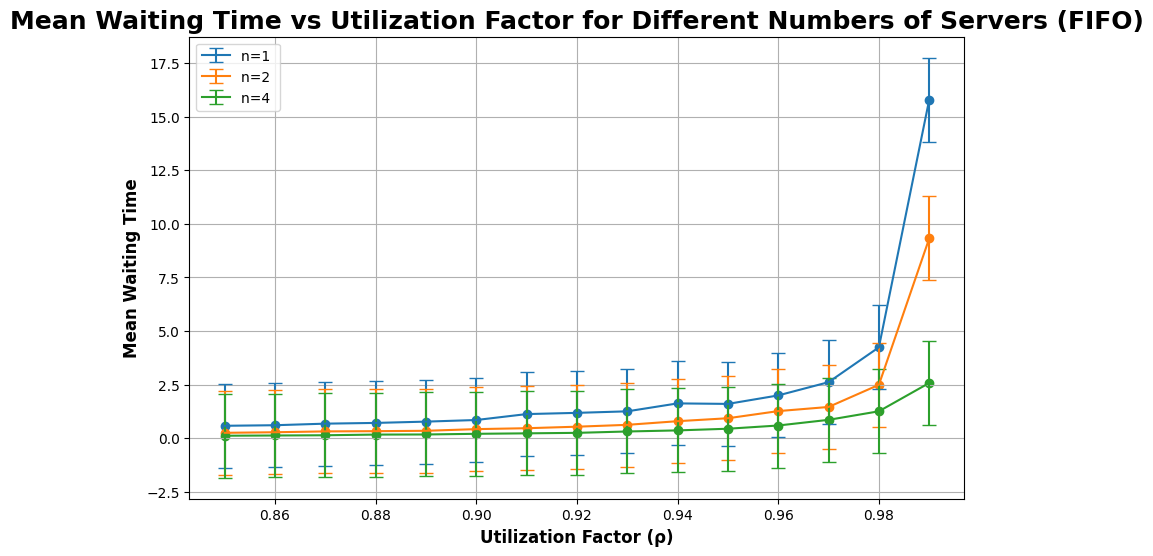

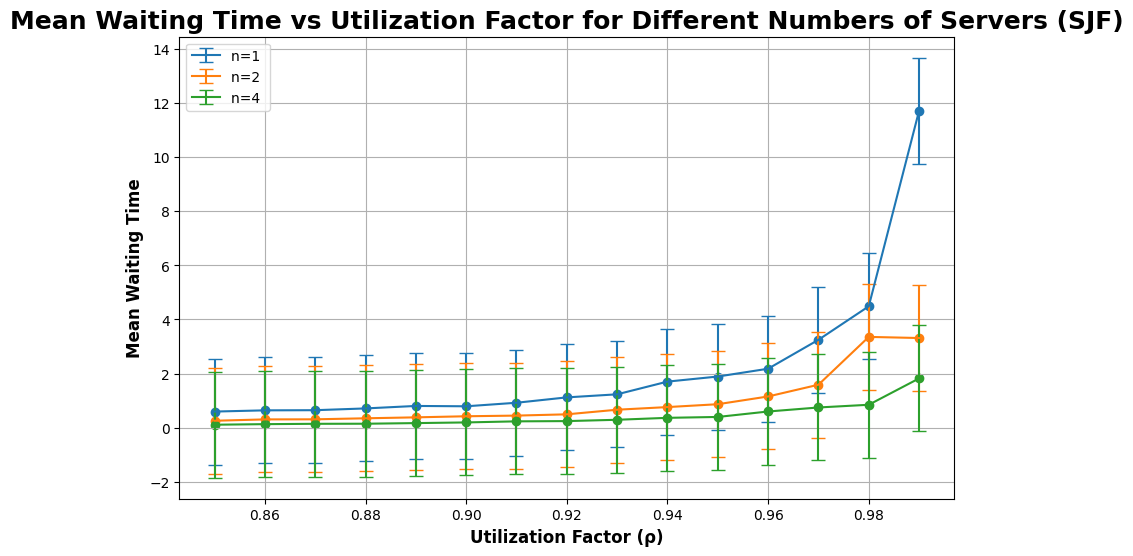

In [128]:
def plotting(results, num_servers, title, results2=None, num_servers2=None):
    plot_data = {}
    for n in num_servers:
        plot_data[n] = []
    for num_server, rho, mean_wait, ci_lower, ci_upper in results:
        plot_data[num_server].append((rho, mean_wait, ci_lower, ci_upper))

    if (results2 != None):
        plot_data2 = {}
        for n in num_servers2:
            plot_data2[n] = []
        for num_server, rho, mean_wait, ci_lower, ci_upper in results2:
            plot_data2[num_server].append((rho, mean_wait, ci_lower, ci_upper))

# for num_servers, rho, mean_wait, ci_lower, ci_upper in results:
#     plt.errorbar(rho, mean_wait, yerr=[[mean_wait - ci_lower], [ci_upper - mean_wait]], fmt='o', label=f'n={num_servers}')


    if (results2 != None):
        string1 = "FIFO"
        string2 = "SJF"
    else:
        string1 = ""
        string2 = ""
# Plotting the results
    color = 0
    plt.figure(figsize=(10, 6))
    for num_server in num_servers:
        rhos, mean_waits, ci_lowers, ci_uppers = zip(*plot_data[num_server])
        # plt.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string1}')
        lower_error = tuple(map(operator.sub, mean_waits, ci_lowers))
        upper_error = tuple(map(operator.sub, ci_uppers, mean_waits))
        plt.errorbar(rhos, mean_waits, yerr=[lower_error, upper_error], fmt='', label=f'n={num_server} {string1}', color=list(mcolors.TABLEAU_COLORS)[color], capsize = 5)
        plt.scatter(rhos, mean_waits, marker='o')
        color += 1
    if (results2 != None):
        for num_server in num_servers2:
            rhos, mean_waits, ci_lowers, ci_uppers = zip(*plot_data2[num_server])
            # plt.plot(rhos, mean_waits, 'o-', label=f'n={num_server} {string2}')
            lower_error = tuple(map(operator.sub, mean_waits, ci_lowers))
            upper_error = tuple(map(operator.sub, ci_uppers, mean_waits))
            plt.errorbar(rhos, mean_waits, yerr=[lower_error, upper_error], fmt='', label=f'n={num_server} {string2}', color=list(mcolors.TABLEAU_COLORS)[color], capsize = 5)
            plt.scatter(rhos, mean_waits, marker='o')
            color += 1

    plt.xlabel('Utilization Factor (ρ)', fontsize=12, fontweight='bold')
    plt.ylabel('Mean Waiting Time', fontsize=12, fontweight='bold')
    plt.title(title, fontsize=18, fontweight='bold')
    plt.legend()
    plt.grid(True)
    plt.show()

# if you want to plot FIFO and SJF together, uncomment the following line
plotting(results_1, NUM_SERVERS_1, "Mean Waiting Time vs Utilization Factor for Different Numbers of Servers", results2=results_2, num_servers2 = NUM_SERVERS_2)

#if you want to plot FIFO and SJF separately, uncomment the following two lines
plotting(results_1, NUM_SERVERS_1, "Mean Waiting Time vs Utilization Factor for Different Numbers of Servers (FIFO)")
plotting(results_2, NUM_SERVERS_2, "Mean Waiting Time vs Utilization Factor for Different Numbers of Servers (SJF)")